In [1]:
import numpy as np
import torch
import tqdm

from dataload import *
from utils import *
from disorder_models import *
%load_ext autoreload
%autoreload 2

In [26]:
dataset = DisorderDataset('data/trizod_embeddings_pdb_1024.h5', 'data/rest_set.tsv', test_perc=0, val_perc=0.15)

In [27]:
print(len(dataset.train_keys))

2054


In [28]:
train_keys, val_keys = dataset.train_keys, dataset.val_keys
train_loader = Dataloader(dataset, train_keys, batch_size=128, shuffle=True)
val_loader = Dataloader(dataset, val_keys, batch_size=128, shuffle=True)

In [32]:
hparams = {
    'epochs': 10,
    'lr':0.001,
    'patience': 5,
    'input_size': 1024,
    'hidden_size': 256,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

In [33]:
model = DisorderNeuralNet(hparams)
model.to(hparams['device'])

DisorderNeuralNet(
  (model): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=model.hparams['lr'])
# optimizer = torch.optim.Adam(model.parameters(), lr=model.hparams['lr'])
criterion = nn.MSELoss()

losses_val = []
losses_train = []

for i in range(hparams['epochs']):
    model.train()
    running_loss = 0.0
    for inputs, targets, _ in tqdm.tqdm(train_loader, desc=f'Epoch {i+1}/{hparams["epochs"]}', maxinterval=len(train_loader)):
        inputs, targets = inputs.to(model.device), targets.to(model.device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.view(-1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses_train.append(running_loss / len(train_loader))


    # do validation
    val_loss = 0.0
    with torch.no_grad():
        val_running_loss = 0.0
        for val_inputs, val_targets, _ in val_loader:
            val_inputs, val_targets = val_inputs.to(model.device), val_targets.to(model.device)
            val_outputs = model(val_inputs)
            val_outputs = val_outputs.view(-1)
            val_loss = criterion(val_outputs, val_targets).item()
            val_running_loss += val_loss

    losses_val.append(val_running_loss / len(val_loader))

Epoch 10/10: 100%|██████████| 17/17 [00:37<00:00,  2.18s/it]


In [ ]:
losses_train

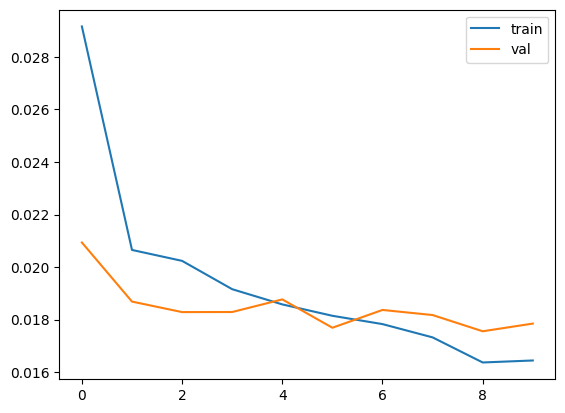

In [35]:
plt.plot(losses_train, label='train')
plt.plot(losses_val, label='val')
plt.legend()
plt.show()

MSE: 0.017002113163471222


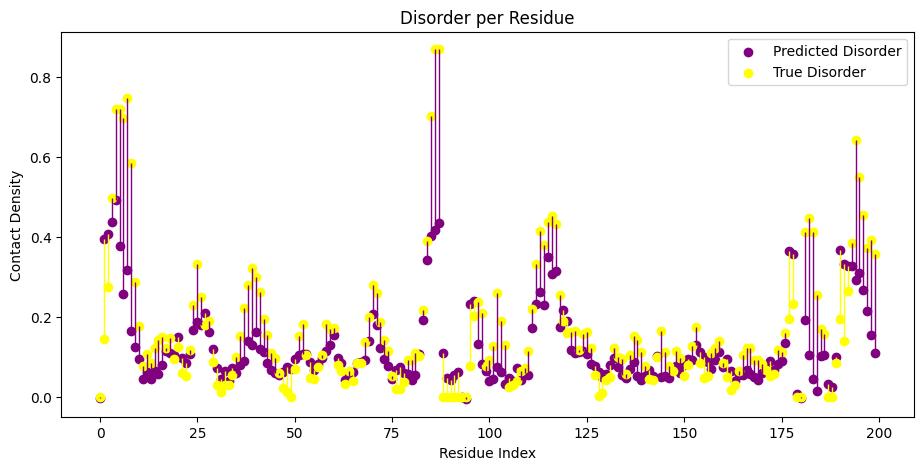

In [36]:
truths = val_targets.cpu().numpy()
preds = val_outputs.detach().cpu().numpy()

# calculate MSE between predictions and truths
mse = np.mean((truths - preds) ** 2)
print(f"MSE: {mse}")

truths = truths[:200]
preds = preds[:200]
mins = [min(truths[i], preds[i]) for i in range(len(truths))]
maxs = [max(truths[i], preds[i]) for i in range(len(truths))]
line_color = ['purple' if preds[i] < truths[i] else 'yellow' for i in range(len(truths))]

plt.figure(figsize=(11, 5))
plt.scatter(range(len(preds)), preds, c='purple', label="Predicted Disorder")
plt.scatter(range(len(truths)), truths, c="yellow", label="True Disorder")
plt.vlines(x=range(len(preds)), linestyle='-', linewidth=1, ymin=mins, ymax=maxs, colors=line_color)
plt.xlabel("Residue Index")
plt.ylabel("Contact Density")
plt.title("Disorder per Residue")
plt.legend()
plt.show()